In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 1.0 * u.centimeter / u.year
model_height = 100. * u.kilometer
viscosityRef = 1e20 * u.pascal * u.second

KL = model_height
Kt = KL / velocity
KM = viscosityRef * KL * Kt

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [4]:
Model = GEO.Model(elementRes=(256, 64), 
                  minCoord=(-200. * u.kilometer,   0. * u.kilometer), 
                  maxCoord=(200. * u.kilometer,  100. * u.kilometer),  
                  gravity=(0.0, -10.0 * u.meter / u.second**2))

In [ ]:
Model.outputDir = "2_09_ShearBandsPureShear"

In [5]:
airLayer = Model.add_material(name="Air", shape=GEO.shapes.Layer2D(top=Model.top, bottom = 80. * u.kilometer))
viscoPlasticLayer = Model.add_material(name="ViscoPlastic", shape=GEO.shapes.Layer2D(top=airLayer.bottom, bottom=10. * u.kilometer))
underLayer = Model.add_material(name="Under", shape=GEO.shapes.Layer2D(top=viscoPlasticLayer.bottom, bottom=Model.bottom))


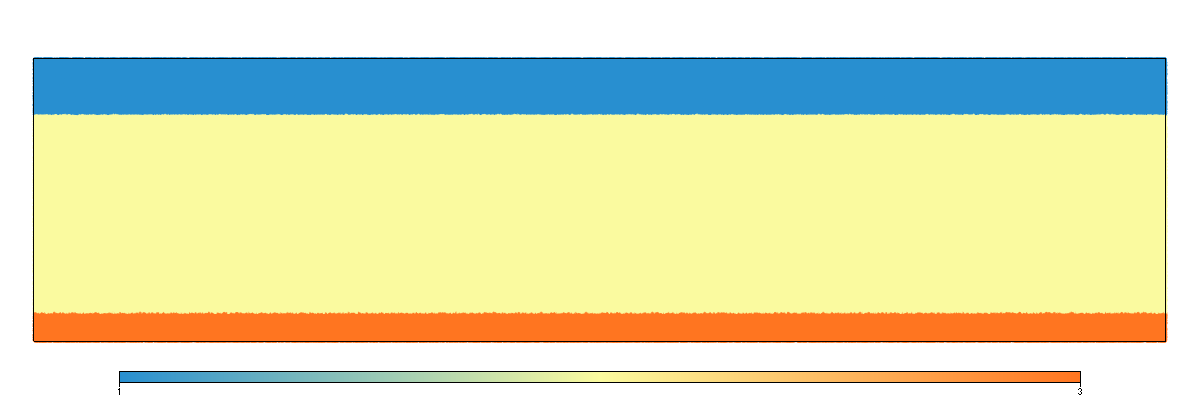

In [6]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=4.0)
Fig.save("Figure_1.png")
Fig.show()

In [7]:
airLayer.density = 0.01 * u.kilogram / u.metre**3
viscoPlasticLayer.density = 0.3 * u.kilogram / u.metre**3
underLayer.density = 3.0 * u.kilogram / u.metre**3

In [8]:
Model.minViscosity = 1e16 * u.pascal * u.second
Model.maxViscosity = 1e21 * u.pascal * u.second

In [9]:
airLayer.viscosity = 1e18  * u.pascal * u.second
viscoPlasticLayer.viscosity = 1e20  * u.pascal * u.second
underLayer.viscosity = 5.0e16  * u.pascal * u.second

In [10]:
viscoPlasticLayer.plasticity  = GEO.DruckerPrager(cohesion=0.32 * u.megapascal,
                                                  cohesionAfterSoftening=0.24 * u.megapascal,
                                                  frictionCoefficient=0.3,
                                                  frictionAfterSoftening=0.3,
                                                  epsilon1=0.0, epsilon2=0.2)

In [11]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.2
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], 0.0, GEO.nd(10. * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], 0.0, GEO.nd(10. * u.kilometer))


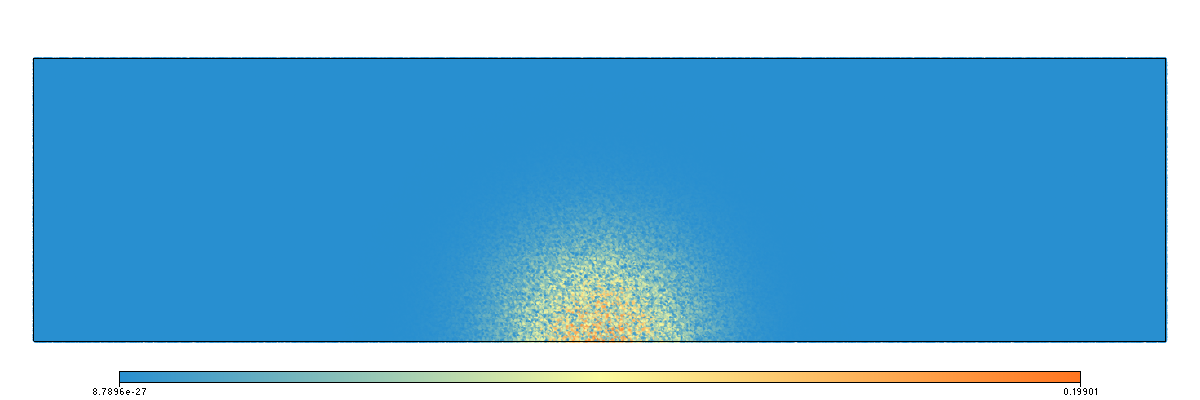

In [12]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.plasticStrain, fn_size=4.0)
Fig.save("Figure_2.png")
Fig.show()

In [13]:
velocityBCs = Model.set_velocityBCs(left=[-1.0 * u.centimeter / u.year, None],
                                    right=[1.0 * u.centimeter / u.year, None],
                                    bottom=[None, 0.])

In [14]:
Model.init_model()

In [15]:
Model.run_for(nstep=5)

Running with UWGeodynamics version 0.9.4-dev-1011449(development)
Step:1 Model Time:  69795.58282576398 year dt: 69795.58282576398 year (2018-11-11 00:58:18)
Step:2 Model Time:  139719.741921973 year dt: 69924.15909620901 year (2018-11-11 00:58:24)
Step:3 Model Time:  209564.1772696649 year dt: 69844.4353476919 year (2018-11-11 00:58:29)
Step:4 Model Time:  279420.05625300435 year dt: 69855.87898333947 year (2018-11-11 00:58:35)
Step:5 Model Time:  349240.18984885176 year dt: 69820.1335958474 year (2018-11-11 00:58:40)


1


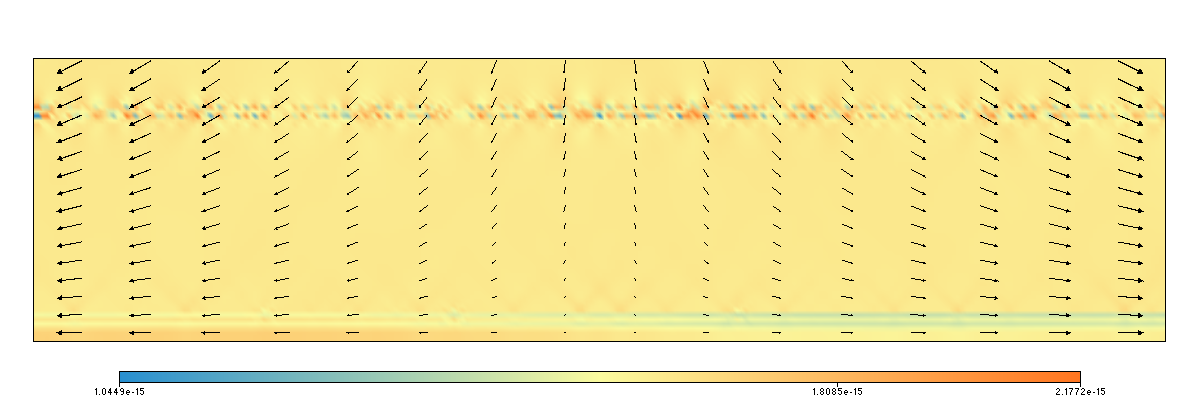

In [16]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.strainRateField, 1.0 / u.second), fn_size=4.0, logScale=True)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_3.png")
Fig.show()